# **Empathy Prediction**

**Most important priority**: Predict polarity (positive, neutral, or negative empathy sentiment). To accomplish this, I trained many sentiment analysis models in increasing complexity. 

**Secondary goal**: Predict empathy from a sentence (happy, tired, angry, etc.).
As there are 62 possible labels, this is a more challenging task that will be dealth with in a secondary model. If this model performed very well, though it could be used as the only model, but otherwise both would be necessary. 


What I did:
1. Pull data
2. Minor data cleaning 
3. Checked for class balances
3. Visualize and Inspect Data by label with pre-trained sentence vectors
5. Message length and label
5. Baseline model with TF-IDF and Naive-Bayes
6. Second model was pre-trained sentence embeddings through ~15 classifiers
7. Third model was fine-tuning BERT to predict positive, neutral, negative
8. Fourth model was fine-tuning BERT to predict empathy labels
9. Analyzed residuals




# Setup

## 1. Libraries

In [ ]:
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import spacy
from sklearn import preprocessing
from tqdm import tqdm
import umap

%matplotlib inline

# Spacy pre-trained English sentence embeddings
!pip install https://github.com/MartinoMensio/spacy-universal-sentence-encoder-tfhub/releases/download/en_use_md-0.2.3/en_use_md-0.2.3.tar.gz#en_use_md-0.2.3

     |████████████████████████████████| 12.1MB 250kB/s 
  Created wheel for en-use-md: filename=en_use_md-0.2.3-cp36-none-any.whl size=12054146 sha256=2bd43744bc29cbd321ed7aead031e27d017cd921b2eafcd1be85c0b2ab068aa1
  Stored in directory: /root/.cache/pip/wheels/ac/72/57/afebe8c2602f0b4c8e995cc6d33aff9299e7b8da7e627c4e16
Successfully built en-use-md


## 2. Data

### Pull in Data


In [ ]:
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1UgmJOsNBKvHiaa5zXi1riAYfD3sTC9Xz")
with open("machine-learning-engineer-takehome_(1).zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('machine-learning-engineer-takehome_(1).zip') as zip:
    zip.extractall('machine_learning_engineer')

### Process and Clean

In [ ]:
labeled_data = pd.read_csv('machine_learning_engineer/machine-learning-engineer/labeled_messages.csv')
# Drop data marked with ignore or without empathy label
labeled_data = labeled_data[labeled_data['ignore'].isna()].drop(['ignore'], axis=1).dropna(axis=0) 

# Expand empathy into multiple labels
max_labels = labeled_data['empathy'].astype(str).apply(lambda x: len(x.split(','))).max()
label_cols = [f'Label_{i}' for i in range(1, max_labels+1)]
labeled_data[label_cols] = labeled_data.empathy.str.split(",", expand=True) 

# Clean spaces
for col in label_cols:
  labeled_data[col] = labeled_data[col].str.strip()

labeled_data

,num_seen,message,empathy,Label_1,Label_2,Label_3,Label_4,Label_5
0,2884,tired,tired,tired,None,None,None,None
1,253,exhausted,tired,tired,None,None,None,None
2,61,drained,tired,tired,None,None,None,None
3,31,tired but happy,"tired, happy",tired,happy,None,None,None
4,30,im tired,tired,tired,None,None,None,None
...,...,...,...,...,...,...,...,...
3557,1,i feel sick but allright,"sick,okay",sick,okay,None,None,None
3558,1,not so good i have a cold,sick,sick,None,None,None,None
3559,1,okay ive just felt a bit angry at my kids but ...,"stress,annoyed",stress,annoyed,None,None,None
3560,1,i am exhausted and i have a headache,"tired,pain",tired,pain,None,None,None


In [ ]:
# Get data
empathies = pd.read_csv('machine_learning_engineer/machine-learning-engineer/empathies.csv')

# Label analysis
data_empathy_labels = [set(labeled_data[f'Label_{i}'].dropna()) for i in range(1, max_labels+1)]
set_of_empathies_in_data = set.union(*data_empathy_labels)
print("Number of unique empathies in data:", len(set_of_empathies_in_data))

print("Number of unique empathies in scores table:", len(set(empathies['empathy'])))

print("Need to label: ", set_of_empathies_in_data.difference(set(empathies['empathy'])))
print()

# Create new labels
new_empathies = pd.DataFrame({'empathy': ['good', 'hopeful', 'frustrated'],
                             'polarity': [1.0, 1.0, -0.8]}
                             )
empathies = empathies.append(new_empathies).reset_index().drop(['index'], axis=1)
empathies

Number of unique empathies in data: 62
Number of unique empathies in scores table: 61
Need to label:  {'good', 'hopeful', 'frustrated'}



,empathy,polarity
0,tired,-0.5
1,great,1.0
2,sad,-1.0
3,anxious,-1.0
4,okay,0.1
...,...,...
59,uncertain,-0.5
60,creative,1.0
61,good,1.0
62,hopeful,1.0


In [ ]:
def pos_neu_neg(row):
  if row == 0: return 1
  elif row < 0: return 0
  else: return 2

def all_labels(row):
  pos_count, neu_count, neg_count = 0, 0, 0
  for score in [val for val in row[[f'Label_{i}' for i in range(1, max_labels+1)]] if not math.isnan(val)]:
    if score > 0: pos_count += 1
    elif score < 0: neg_count += 1
    else: neu_count += 1
  
  if pos_count > 0:
    if neg_count == 0 and neu_count == 0:
      return 'pos_only'
    elif neg_count > 0 and neu_count == 0:
      return 'pos_and_neg'
    elif neg_count == 0 and neu_count > 0:
      return 'pos_and_neu'
    else:
      return 'all_types'
  elif neg_count > 0:
    if neu_count == 0:
      return 'neg_only'
    else:
      return 'neg_and_neu'
  else:
    return 'neu_only'

empathy_score_table = labeled_data.copy().reset_index()
for col in label_cols:
  empathy_score_table[col] = pd.DataFrame(empathy_score_table[col]).merge(empathies, how="left", left_on=col, right_on="empathy").reset_index()['polarity']

# Interpretable labels for EDA
empathy_score_table['poss_labels'] = empathy_score_table.apply(lambda x: all_labels(x), axis=1)
empathy_score_table = empathy_score_table.fillna(0)

# Total Values for EDA
empathy_score_table['total'] = empathy_score_table.apply(lambda x: np.array([x[col] for col in label_cols]).sum(), axis=1)

# Number of labels count for EDA
num_labels = (5 - labeled_data[[f'Label_{i}' for i in range(1, max_labels+1)]].isnull().sum(axis=1)).rename("number_of_labels")
empathy_score_table['num_labels'] = num_labels.copy().astype('int32')

# Numerical score for prediction labels
empathy_score_table['pos_neu_neg'] = empathy_score_table.apply(lambda x: pos_neu_neg(x['total']), axis=1)

empathy_score_table

,index,num_seen,message,empathy,Label_1,Label_2,Label_3,Label_4,Label_5,poss_labels,total,num_labels,pos_neu_neg
0,0,2884,tired,tired,-0.5,0.0,0.0,0.0,0.0,neg_only,-0.5,1.0,0
1,1,253,exhausted,tired,-0.5,0.0,0.0,0.0,0.0,neg_only,-0.5,1.0,0
2,2,61,drained,tired,-0.5,0.0,0.0,0.0,0.0,neg_only,-0.5,1.0,0
3,3,31,tired but happy,"tired, happy",-0.5,1.0,0.0,0.0,0.0,pos_and_neg,0.5,2.0,2
4,4,30,im tired,tired,-0.5,0.0,0.0,0.0,0.0,neg_only,-0.5,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,3557,1,i feel sick but allright,"sick,okay",-0.2,0.1,0.0,0.0,0.0,pos_and_neg,-0.1,2.0,0
3556,3558,1,not so good i have a cold,sick,-0.2,0.0,0.0,0.0,0.0,neg_only,-0.2,2.0,0
3557,3559,1,okay ive just felt a bit angry at my kids but ...,"stress,annoyed",-0.1,-0.8,0.0,0.0,0.0,neg_only,-0.9,2.0,0
3558,3560,1,i am exhausted and i have a headache,"tired,pain",-0.5,-1.0,0.0,0.0,0.0,neg_only,-1.5,1.0,0


# EDA


### Class Balances


In [ ]:
fig = px.histogram(empathies, title="Polarity of Empathy Labels", x="polarity")
fig.show()

In [ ]:
fig = px.histogram(empathy_score_table, title="Distribution of Sum of Polarities by Message ", x="total")
fig.show()

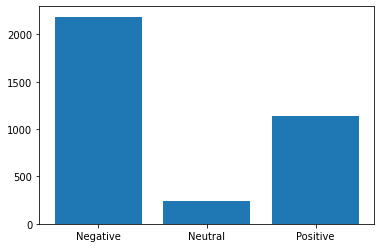

In [ ]:
counts = dict(empathy_score_table['pos_neu_neg'].value_counts())
counts_dict = {'Negative': counts[0],
                        'Neutral': counts[1],
                        'Positive': counts[2]}
plt.bar(x=counts_dict.keys(), height=counts_dict.values());

Data does have class imbalances, so oversampling and undersampling could be good!




In [ ]:
fig = px.histogram(num_labels, title="Number of Labels", x="number_of_labels")
fig.show()

### Data Inspection

In [ ]:
# Inspect Data
nlp = spacy.load('en_use_md')
empathy_score_table["vectors"] = empathy_score_table["message"].apply(lambda x: nlp(x).vector)
vectorized_features = np.vstack(empathy_score_table["vectors"])

In [ ]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

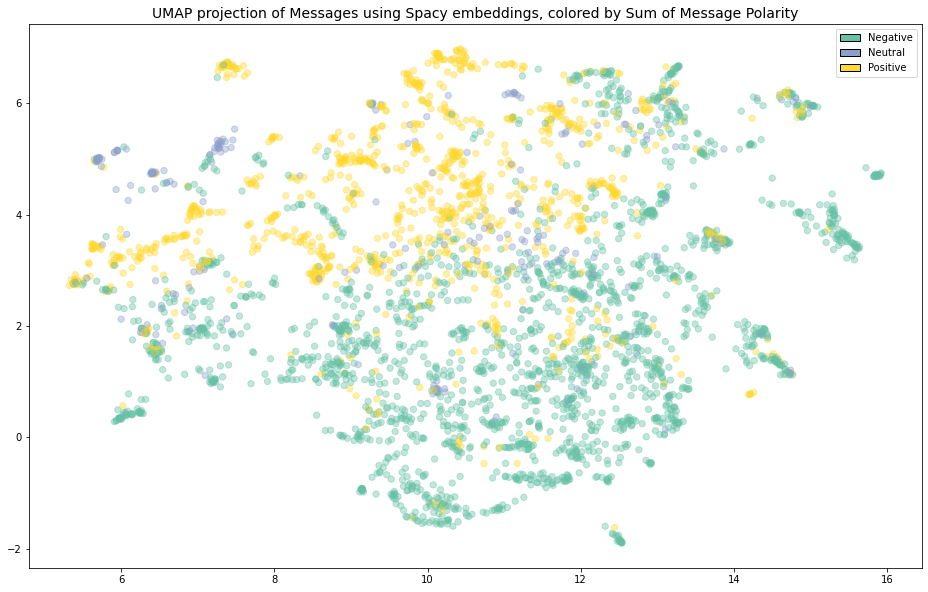

In [ ]:
# Choose number of clusters and colormap
n_clusters=len(set(empathy_score_table["pos_neu_neg"]))
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=cmap(empathy_score_table["pos_neu_neg"]/n_clusters), s=40, alpha=.4)
plt.title('UMAP projection of Messages using Spacy embeddings, colored by Sum of Message Polarity', fontsize=14)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_clusters) for x in [i for i in range(n_clusters)]]
]

labels = ['Negative', 'Neutral', 'Positive']
plt.legend(handles, labels)
plt.show()


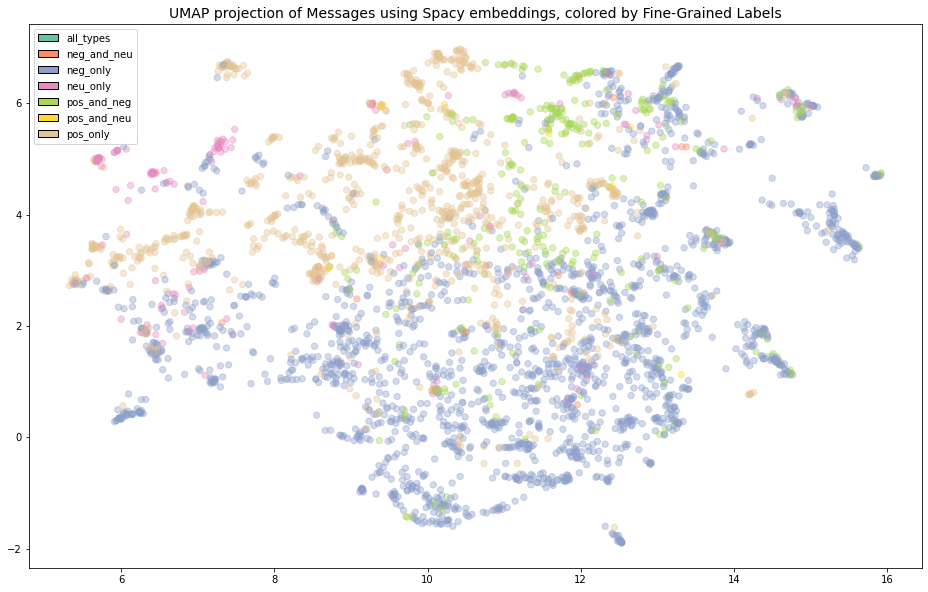

In [ ]:
# Choose number of clusters and colormap
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(empathy_score_table['poss_labels'])

n_clusters=len(set(empathy_score_table["poss_labels"]))
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=cmap(encoded_labels/n_clusters), s=40, alpha=.4)
plt.title('UMAP projection of Messages using Spacy embeddings, colored by Fine-Grained Labels', fontsize=14)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_clusters) for x in [i for i in range(n_clusters)]]
]

labels = le.classes_
plt.legend(handles, labels)
plt.show()

Label Type Counts

neg_only       2085
pos_only        953
pos_and_neg     324
neu_only        162
neg_and_neu      21
pos_and_neu      14
all_types         1
Name: poss_labels, dtype: int64



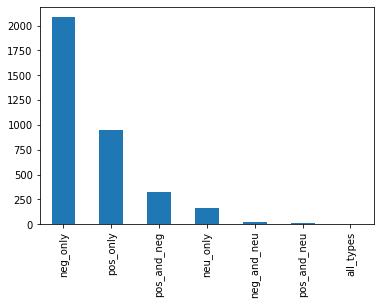

In [ ]:
print("Label Type Counts")
print()
print(empathy_score_table['poss_labels'].value_counts());
print()
empathy_score_table['poss_labels'].value_counts().plot(kind='bar');

Message Analysis by Labels:
- Messages with **only positive** labels: Generally pretty distinct, should be easy to predict
- Messages with **positive and neutral** labels: pretty mixed up with positive and negatively labeled message. Need to examine total polarity.
- Messages with **positive and negative** labels: These will be the hardest to predict, unsuprisingly. Need to examine total polarity to see how much of a problem this will really be.
- Messages with **only negative** labels: Fairly distinct, but a bit of overlap with neutral labels. Messages with both positive and negative labels are mixed in well also.
- Messages with **negative and neutral** labels: Nearly always in a negative zone, so these shouldn't be hard to identify.
- Messages with **only netural** labels: Some seem obvious, but others are certainly less so. It is helpful that they are generally between positive and negative labels.
- Messages with **all three** labels: there are only one of these, so not worried

TO DO:
- Check positive and negative, positive and neutral in terms of polarity



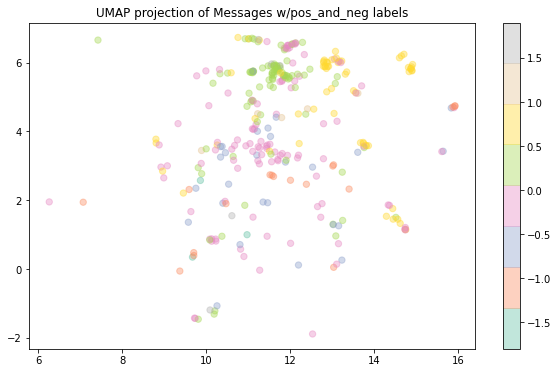

In [ ]:
# Choose number of clusters and colormap
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(10, 6))

# Check positive and negative, positive and neutral in terms of polarity
labels = [4] # both positive and negative labels present
labels_to_check = [True if lbl in labels else False for lbl in encoded_labels]

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0][labels_to_check], umap_features[:, 1][labels_to_check], 
            c=empathy_score_table["total"][labels_to_check], 
            s=40, 
            alpha=.4,
            cmap=cmap)
handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_clusters) for x in [i for i in labels]]
]


plt.title(f'UMAP projection of Messages w/{le.classes_[labels][0]} labels');

plt.colorbar()
plt.show()

If both positive and negative labels are present:
  - The polarity can be anything
  - The types of messages are diverse, as shown by the distribution of the points across the plot (message embeddings with reduced dimensions)

It seems like these will be the hardest to predict polarity for.


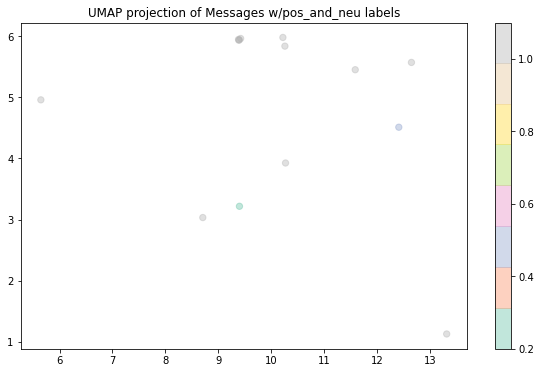

In [ ]:
# Choose number of clusters and colormap
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(10, 6))

# Check positive and negative, positive and neutral in terms of polarity
labels = [5] # both positive and neutral labels present
labels_to_check = [True if lbl in labels else False for lbl in encoded_labels]

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0][labels_to_check], umap_features[:, 1][labels_to_check], 
            c=empathy_score_table["total"][labels_to_check], 
            s=40, 
            alpha=.4,
            cmap=cmap)
handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_clusters) for x in [i for i in labels]]
]


plt.title(f'UMAP projection of Messages w/{le.classes_[labels][0]} labels');

plt.colorbar()
plt.show()

While messages with both positive and neutral labels differ considerably, as shown by the distribution of points, the polarity is consistent at least, so that should make it easier than for positive and negative labels.


## Message Length

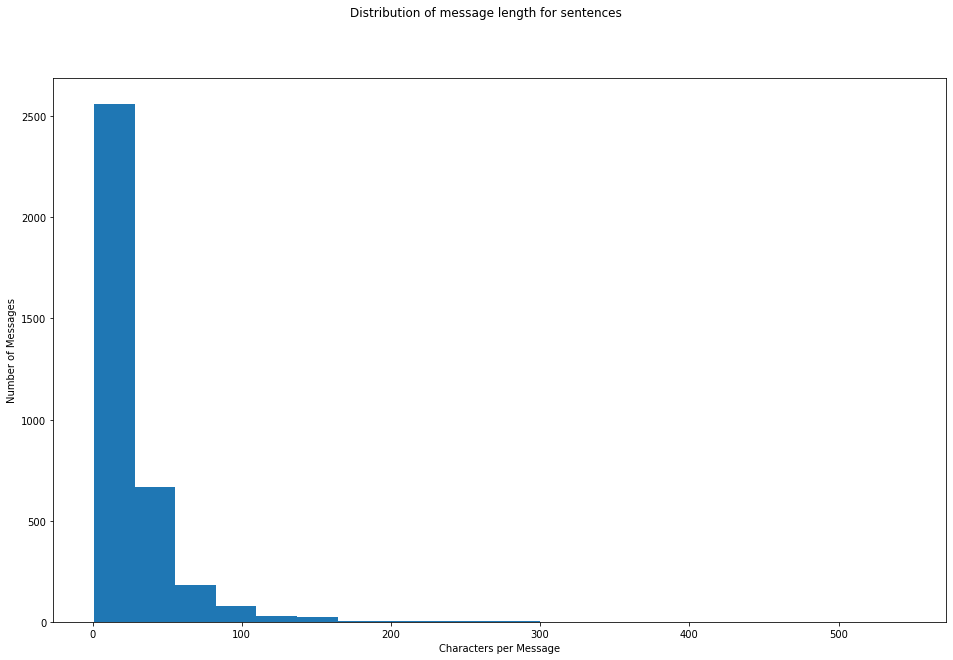

In [ ]:
empathy_score_table['text_len'] = empathy_score_table.apply(lambda x: len(x['message']), axis=1)

fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of message length for sentences")
plt.xlabel("Characters per Message")
plt.ylabel("Number of Messages")
q_len = plt.hist(empathy_score_table["text_len"],  bins=20,log=False)

Looks like a few outliers. I wonder is sentence length is predictive of polarity?


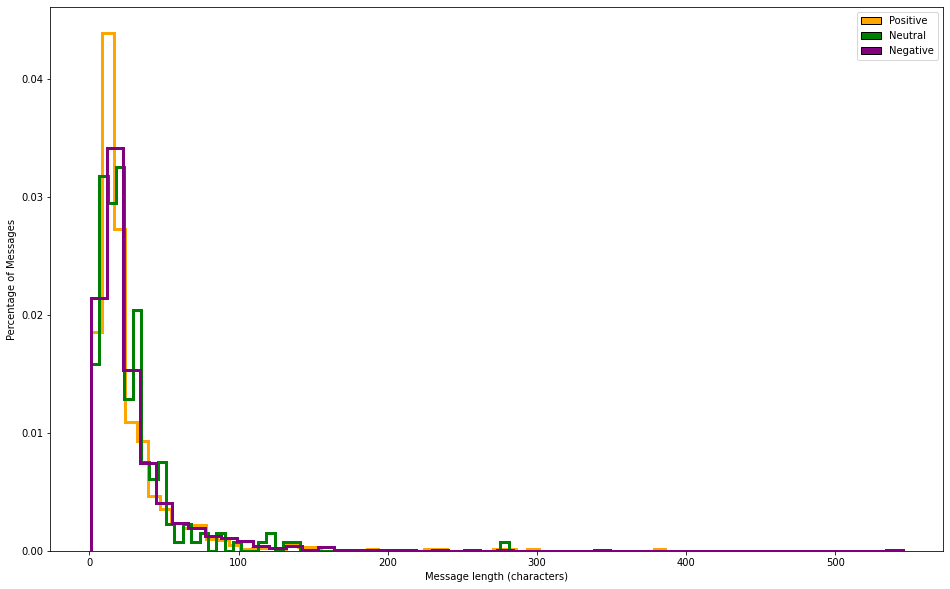

In [ ]:
ax = empathy_score_table[empathy_score_table['pos_neu_neg'] == 2]["text_len"].hist(
    bins=50,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid=False,
    figsize=(16, 10),
)

empathy_score_table[empathy_score_table['pos_neu_neg'] == 1]["text_len"].hist(
    bins=50,
    density=True,
    histtype="step",
    color="green",
    linewidth=3,
    grid=False,
)

empathy_score_table[empathy_score_table['pos_neu_neg'] == 0]["text_len"].hist(
    bins=50,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=False,
)
handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["orange", "green", "purple"]
]

labels = ["Positive", "Neutral", "Negative"]
plt.legend(handles, labels)
ax.set_xlabel("Message length (characters)")
ax.set_ylabel("Percentage of Messages");

Positive messages tend to be shorter on average and negative messages seem to be longer. Also, there don't appear to be any very long neutral messages. This suggests that we should try message length as a feature in the model.

# Models to Predict Positive, Neutral, or Negative Labels


## 1. Baseline Model: Naive Bayes with TF-IDF

TF-IDF was one of the first NLP vectorization techniques, improving performance of the Bag of Words strategy. 

We'll use these vectors in conjunction with Naive Bayes, the canonical NLP ML algorithm which handles high dimensionality of the data well by using probabilities, avoiding the 'curse of dimensionality.'




#### Data Preparation

In [ ]:
empathy_data = empathy_score_table[['index', 'message', 'total', 'pos_neu_neg']]
empathy_data

,index,message,total,pos_neu_neg
0,0,tired,-0.5,0
1,1,exhausted,-0.5,0
2,2,drained,-0.5,0
3,3,tired but happy,0.5,2
4,4,im tired,-0.5,0
...,...,...,...,...
3555,3557,i feel sick but allright,-0.1,0
3556,3558,not so good i have a cold,-0.2,0
3557,3559,okay ive just felt a bit angry at my kids but ...,-0.9,0
3558,3560,i am exhausted and i have a headache,-1.5,0


In [ ]:
from sklearn.model_selection import train_test_split

X = empathy_data.message.values
y = empathy_data.pos_neu_neg.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

#### Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    The data has already been cleaned, but let's deal with negation.
    - Change "nt" to "not" (apostrophe's have been cleaned)
    - Remove stop words except "not" and "can"
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"nt", " not", s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### TF-IDF

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(message) for message in X_train])
X_val_preprocessed = np.array([text_preprocessing(message) for message in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 2.22 s, sys: 321 ms, total: 2.54 s
Wall time: 2.56 s


#### Train Model

### Hyperparameter Tuning

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.0


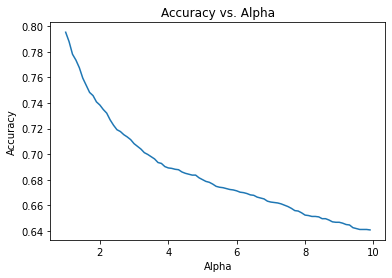

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB

def get_acc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=2020)

    # Get AUC scores
    acc = cross_val_score(
        model, X_train_tfidf, y_train, cv=kf)

    return acc.mean()

res = pd.Series([get_acc_CV(MultinomialNB(i))
                  for i in np.arange(1, 10, 0.1)],
                  index=np.arange(1, 10, 0.1),)

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('Accuracy vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

### Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def score_model(preds, true):
  print("Weighted F1:", round(f1_score(true, preds, average='weighted'), 2))
  print("Acc:", round(accuracy_score(true, preds), 2))
  print("Recall:")
  rec = recall_score(true, preds, average=None, zero_division=0)
  print(f"  Neg. Label: {round(rec[0], 3)},\n  Neu. Label: {round(rec[1], 3)},\n  Pos. Label: {round(rec[2], 3)}")
  print("Precision:")
  prc = precision_score(true, preds, average=None, zero_division=0)
  print(f"  Neg. Label: {round(prc[0], 3)},\n  Neu. Label: {round(prc[1], 3)},\n  Pos. Label: {round(prc[2], 3)}")
  print()

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_tfidf, y_train)
preds = nb_model.predict(X_val_tfidf)

# Evaluate the classifier
score_model(preds, y_val)

Weighted F1: 0.78
Acc: 0.81
Recall:
  Neg. Label: 0.995,
  Neu. Label: 0.0,
  Pos. Label: 0.633
Precision:
  Neg. Label: 0.771,
  Neu. Label: 0.0,
  Pos. Label: 0.968



#### **F1-score: 78%**

- Positive labels: Gets almost all, but predicts it too much.
- Neutral labels: Never predicts neutral! That's a problem. :)
- Negative labels: Always gets Negative right, but doesn't predict it enough.

### Explain Model

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer
import sklearn
from sklearn.pipeline import make_pipeline

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=064bb1f770266092e1ce96500fc060f5366cca9245f6f73b54cbf6d1e1af8aae
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
c = make_pipeline(tf_idf, nb_model)
class_names = ['Negative', 'Neutral', 'Positive']
explainer = LimeTextExplainer(class_names=class_names)

# Choose a message!
idx = 3559
exp = explainer.explain_instance(empathy_data.message[idx], c.predict_proba, num_features=6, top_labels=10)
exp.show_in_notebook(text=empathy_data.message[idx])

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning:

split() requires a non-empty pattern match.



## Pretrained Sentence Encodings + Message Length


### Train Every Sklearn Classifier

In [ ]:
import tensorflow as tf
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

features = empathy_score_table['vectors'].apply(pd.Series)
# add message length for good measure
features['msg_length'] = empathy_score_table['text_len']

X = features.values
y = empathy_data.pos_neu_neg.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.

100%|██████████| 30/30 [02:19<00:00,  4.65s/it]


In [ ]:
models[['F1 Score', 'Time Taken']].sort_values('F1 Score', ascending=False)

,F1 Score,Time Taken
Model,,
SVC,0.87,4.40
Perceptron,0.86,0.27
KNeighborsClassifier,0.86,1.26
XGBClassifier,0.85,30.09
RidgeClassifierCV,0.84,0.59
LinearDiscriminantAnalysis,0.84,0.69
LogisticRegression,0.84,0.98
LGBMClassifier,0.84,39.38
RidgeClassifier,0.84,0.14


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)
preds = clf.predict(X_val)

In [ ]:
# Evaluate the classifier
score_model(preds, y_val)

Weighted F1: 0.87
Acc: 0.89
Recall:
  Neg. Label: 0.97,
  Neu. Label: 0.174,
  Pos. Label: 0.893
Precision:
  Neg. Label: 0.875,
  Neu. Label: 0.8,
  Pos. Label: 0.921



#### **F1-score (SVM): 87%**

- Positive labels: Does well, and good precision too
- Neutral labels: Doesn't usually guess it
- Negative labels: Always gets Negative right, but doesn't predict it enough.

## DistilBert Transfer Learning
Lightweight BERT Model

#### 3. Set Up GPU

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [ ]:
device

device(type='cuda')

In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 890kB 11.2MB/s 
     |████████████████████████████████| 3.7MB 25.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=18570918ac41a15dd828dcae6e3a74d551db2777faf5e8a82136f5b2ef84bf68
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


#### Prepare Data and Model

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Concatenate train data and test data
all_messages = empathy_data.message.values

# Encode our concatenated data
encoded_messages = [tokenizer.encode(msg, add_special_tokens=True) for msg in all_messages]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_messages])
print('Max length: ', max_len)

# Defining some key variables that will be used later on in the training
MAX_LEN = max_len
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05

Max length:  135


In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42) 

In [ ]:
class LoadData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.message[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.pos_neu_neg[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset = empathy_data.sample(frac=train_size,random_state=200)
test_dataset = empathy_data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(empathy_data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = LoadData(train_dataset, tokenizer, MAX_LEN)
testing_set = LoadData(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3560, 4)
TRAIN Dataset: (2848, 4)
TEST Dataset: (712, 4)


In [ ]:
training_set.__getitem__(1)

{'ids': tensor([ 101, 4064, 1045, 4857,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]),
 'mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        output_1= self.l1(ids, mask)
        output_2 = self.l2(output_1[0])
        output = self.l3(output_2)
        return output

In [ ]:
distilbert = DistillBERTClass()
distilbert.to(device)

# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  distilbert.parameters(), lr=LEARNING_RATE)


In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(model, epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask).squeeze()

        optimizer.zero_grad()
        loss = loss_function(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#### Train

In [ ]:
for epoch in range(EPOCHS):
    train(distilbert, epoch)

Epoch: 0, Loss:  4.786592960357666
Epoch: 1, Loss:  0.3386964201927185
Epoch: 2, Loss:  0.04120519384741783
Epoch: 3, Loss:  0.3072478473186493


In [ ]:
def validation(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask).squeeze()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets


# Get validation results
probs, y_val = validation(distilbert)
distilbert_preds = np.array(probs).argmax(axis=1)
score_model(distilbert_preds, y_val)

Weighted F1: 0.83
Acc: 0.84
Recall:
  Neg. Label: 0.944,
  Neu. Label: 0.259,
  Pos. Label: 0.796
Precision:
  Neg. Label: 0.86,
  Neu. Label: 0.737,
  Pos. Label: 0.824



#### **F1-score (DistilBert): 83%**

- Positive labels: Does very well, and good precision too.
- Neutral labels: Get some of them, but good precision.
- Negative labels: Does very well, and good precision too.

## Larger BERT Model

### Tokenizer

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_len

X = empathy_data.message.values
y = empathy_data.pos_neu_neg.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[3559]])[0].squeeze().numpy())
print('Original: ', X[3559])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  im feeling good but a bit sick
Token IDs:  [101, 10047, 3110, 2204, 2978, 5305, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Train

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Authors of BERT paper recommend the following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=True):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(b.to(device) for b in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.731547   |     -      |     -     |   28.42  
   1    |   40    |   0.552590   |     -      |     -     |   27.00  
   1    |   60    |   0.420200   |     -      |     -     |   26.95  
   1    |   80    |   0.410166   |     -      |     -     |   26.90  
   1    |   88    |   0.397030   |     -      |     -     |   10.75  
----------------------------------------------------------------------
   1    |    -    |   0.519077   |  0.342511  |   87.77   |  131.23  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.307651   |     -      |     -     |   28.26  
   2    |   40    |   0.304345   |     -      |     -     |   26

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
bert_preds = probs.argmax(axis=1)
score_model(bert_preds, y_val)

Weighted F1: 0.9
Acc: 0.91
Recall:
  Neg. Label: 0.974,
  Neu. Label: 0.476,
  Pos. Label: 0.862
Precision:
  Neg. Label: 0.89,
  Neu. Label: 0.769,
  Pos. Label: 0.963



### **F1-score (Larger Bert): 90%**

- Positive labels: Does very well, and good precision too.
- Neutral labels: Good results.
- Negative labels: Great results.

# Model to Predict Empathy

### Data Preparation

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
multilabel_encoding = mlb.fit_transform(labeled_data.empathy.str.split(",").apply(lambda x: [word.strip() for word in x]))
empathy_data['multilabels'] = pd.Series(list(multilabel_encoding))

train_size = 0.8
train_dataset = empathy_data.sample(frac=train_size,random_state=200)
test_dataset = empathy_data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

MAX_LEN = max_len
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 24
LEARNING_RATE = 1e-05
#WEIGHT_DECAY = .05

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.message
        self.orig_idx = dataframe.index
        self.targets = dataframe.multilabels
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'idx': torch.tensor(self.orig_idx[index], dtype=torch.long)
        }

training_set = MultiLabelDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_dataset, tokenizer, MAX_LEN)

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        #self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 62)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        #output_2 = self.l2(output_1)
        output = self.l3(output_1)
        return output

model = BERTClass()
model.to(device)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam( params =  model.parameters(), lr=LEARNING_RATE)#, weight_decay=WEIGHT_DECAY)

### Train Model

In [ ]:
def train(epoch,  evaluation=True):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Training complete!")
        
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def validation(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_logits=[]
    orig_indices = []


    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            indices = data['idx'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            orig_indices.extend(indices.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
            fin_logits.extend(logits.cpu().detach().numpy().tolist())
    return fin_logits, fin_outputs, fin_targets, orig_indices

result_logits, outputs, y_val, indices = validation(model)

### Evaluate

Find the best threshold, important for multilabel problem

Best F1 threshold: 0.23, Weighted F1: 0.75
Best Recall threshold: 0.0, Recall: 1.0
Best Precision threshold: 0.49, Recall: 0.84


''

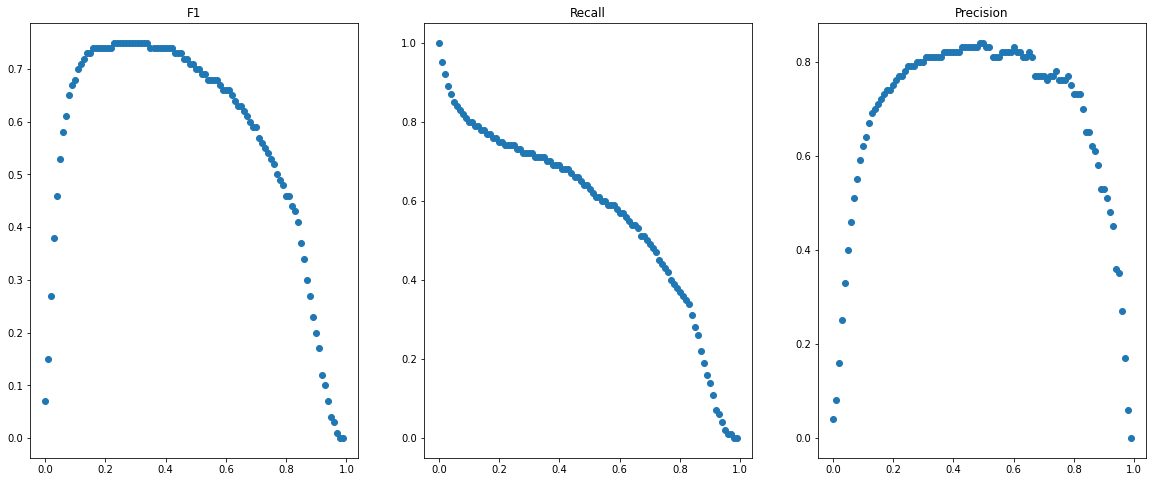

In [ ]:
f1_results = {i/100: round(f1_score(y_val, np.array(outputs) >= i/100, average='weighted'), 2) for i in range(100)}
rec_results = {i/100: round(recall_score(y_val, np.array(outputs) >= i/100, average='weighted'), 2) for i in range(100)}
prec_results = {i/100: round(precision_score(y_val, np.array(outputs) >= i/100, average='weighted'), 2) for i in range(100)}

max_key_f1 = max(f1_results, key=f1_results.get)
max_key_rec = max(rec_results, key=rec_results.get)
max_key_prc = max(prec_results, key=prec_results.get)
print(f"Best F1 threshold: {max_key_f1}, Weighted F1: {f1_results[max_key_f1]}")
print(f"Best Recall threshold: {max_key_rec}, Recall: {rec_results[max_key_rec]}")
print(f"Best Precision threshold: {max_key_prc}, Recall: {prec_results[max_key_prc]}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
ax1.scatter(x=list(f1_results.keys()), y=list(f1_results.values()))
ax1.title.set_text('F1')
ax2.scatter(x=list(rec_results.keys()), y=list(rec_results.values()))
ax2.title.set_text('Recall')
ax3.scatter(x=list(prec_results.keys()), y=list(prec_results.values()))
ax3.title.set_text('Precision')
;

Weighted F1 across training:
-  6 epochs val weighted F1: .22
- 12 epochs val weighted F1: .62
- 18 epochs val weighted F1: .77
- 24 epochs val weighted F1: .80

### **Empathy F1-score: 80%**

### Results & Residuals

In [ ]:
preds = np.array(outputs) >= max_key_f1

results_df = pd.DataFrame()
results_df['index'] = indices
results_df['message'] = empathy_score_table.loc[indices,:]['message'].reset_index()['message']
results_df['predictions'] = mlb.inverse_transform(preds)
results_df['empathy'] = empathy_score_table.loc[indices,:]['empathy'].reset_index()['empathy']
results_df['num_labels'] = empathy_score_table.loc[indices,:]['num_labels'].reset_index()['num_labels']
results_df['pos_neu_neg'] = empathy_score_table.loc[indices,:]['pos_neu_neg'].reset_index()['pos_neu_neg']
results_df['total'] = empathy_score_table.loc[indices,:]['total'].reset_index()['total']
results_df['poss_labels'] = empathy_score_table.loc[indices,:]['poss_labels'].reset_index()['poss_labels']

# What is our predicted total polarity and how does it compare to the actual total polarity?
label_vals = pd.DataFrame({"labels": list(mlb.classes_)}).merge(empathies, how='left', left_on='labels', right_on='empathy')['polarity'].to_list()
empathy_polarity_pred = np.multiply(np.tile(label_vals, (np.array(outputs).shape[0], 1)), np.array(outputs))
predicted_total = empathy_polarity_pred.sum(axis=1)
results_df['predicted_total'] = predicted_total
results_df['pred_pos_neu_neg'] = results_df.apply(lambda x: pos_neu_neg(x['predicted_total']), axis=1)
results_df

,index,message,predictions,empathy,num_labels,pos_neu_neg,total,poss_labels,predicted_total,pred_pos_neu_neg
0,269,extremely sad,"(disconnected, emotionless)",sad,1.00,0,-1.00,neg_only,-0.40,0
1,619,depressed it just feels like im making everyon...,"(okay,)",depressed,1.00,0,-1.00,neg_only,0.07,2
2,231,bothered,"(better,)",sad,1.00,0,-1.00,neg_only,0.11,2
3,325,worry,"(determined,)",anxious,1.00,0,-1.00,neg_only,0.61,2
4,528,stressed and sleepy,"(uneasy,)","stress, sleep",2.00,0,-0.20,neg_only,-0.46,0
...,...,...,...,...,...,...,...,...,...,...
707,125,pleased,"(stable,)",happy,1.00,2,1.00,pos_only,0.26,2
708,344,somewhat anxious,"(calm, happy, hungry)",anxious,1.00,0,-1.00,neg_only,0.72,2
709,576,its finals time so a little stressed,"(happy, stable)",stress,1.00,0,-0.10,neg_only,1.40,2
710,641,depressed down twisted up inside,"(excited,)",depressed,1.00,0,-1.00,neg_only,0.94,2


#### Only One Model?

With a larger NLP model and more training, it could be possible to consolidate these two tasks into one model, but the model would have to be more performant.

In [ ]:
score_model(results_df['pred_pos_neu_neg'], results_df['pos_neu_neg'])

Weighted F1: 0.55
Acc: 0.55
Recall:
  Neg. Label: 0.667,
  Neu. Label: 0.0,
  Pos. Label: 0.325
Precision:
  Neg. Label: 0.665,
  Neu. Label: 0.0,
  Pos. Label: 0.319



In [ ]:
analysis_df = pd.DataFrame({"classes": mlb.classes_, "recall": recall_score(y_val, preds, average=None)})
analysis_df['empathy']  = pd.DataFrame({"labels": list(mlb.classes_)}).merge(empathies, how='left', left_on='labels', right_on='empathy')['polarity'].to_list()
analysis_df['pos_neu_neg'] = analysis_df.apply(lambda x: pos_neu_neg(x['empathy']), axis=1)
analysis_df['validation_label_count'] = np.array(list(test_dataset['multilabels'])).sum(axis=0)
analysis_df

,classes,recall,empathy,pos_neu_neg,validation_label_count
0,affectionate,0.40,1.00,2,5
1,angry,0.90,-1.00,0,29
2,annoyed,0.89,-0.80,0,35
3,anxious,0.70,-1.00,0,33
4,average,0.70,0.00,1,27
...,...,...,...,...,...
57,uneasy,0.83,-0.50,0,6
58,unmotivated,0.89,-0.80,0,18
59,unsatisfied,0.75,-0.50,0,12
60,upset,0.00,-0.90,0,15


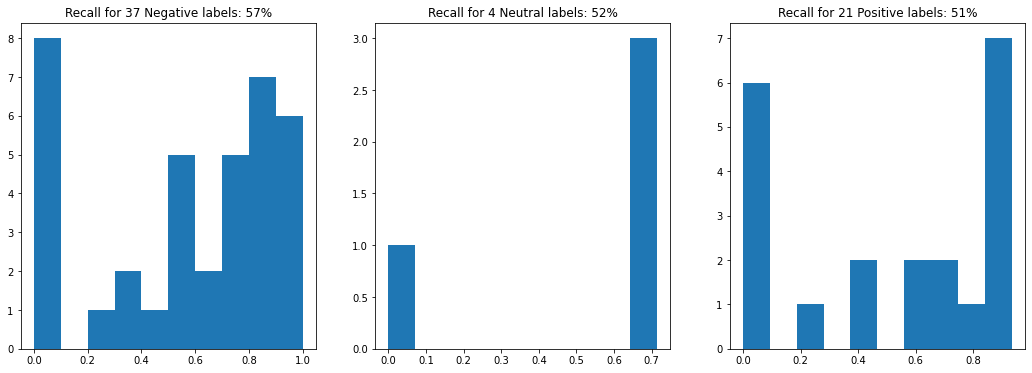

In [ ]:
fig, ax = plt.subplots(1, 3, figsize= (18,6))
labels = ['Negative', 'Neutral', 'Positive']
for i in range(3): 
  ax[i].hist(analysis_df['recall'][analysis_df['pos_neu_neg'] == i])
  word_count = analysis_df['validation_label_count'][analysis_df['pos_neu_neg'] == i].count()
  ax[i].title.set_text(f"Recall for {word_count} {labels[i]} labels: {int(100*round(analysis_df['recall'][analysis_df['pos_neu_neg'] == i].mean(),2))}%")


#### How many times is no label predicted?

In [ ]:
import plotly.graph_objects as go

# How may predict no label?
label_pred_counts = pd.Series((preds*1).sum(axis=1)).value_counts().to_dict()
actual_label_counts = results_df['num_labels'].value_counts().to_dict()
print("No predictions at all:", pd.Series((preds*1).sum(axis=1)).value_counts()[0])

fig = go.Figure(data=[
    go.Bar(name='Predicted Label Counts', x=list(label_pred_counts.keys()), y=list(label_pred_counts.values())),
    go.Bar(name='Actual Label Counts', x=list(label_pred_counts.keys()), y=list(actual_label_counts.values()))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title_text='Number of Labels Predicted for Validation Data')
fig.show()

No predictions at all: 35


Where were the poor predictions? Let's mark quality of prediction based on polarity of prediction.

In [ ]:
vectorized_features = np.vstack(np.array(result_logits))
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

In [ ]:
# two plots
# 1. pos neg neu 2. correct or incorrect
results_df['right_wrong_pred_polarity'] = results_df.apply(lambda x: x['total']==x['predicted_total'] or x['total']/(x['predicted_total']+.001) > 0, axis=1)*1 

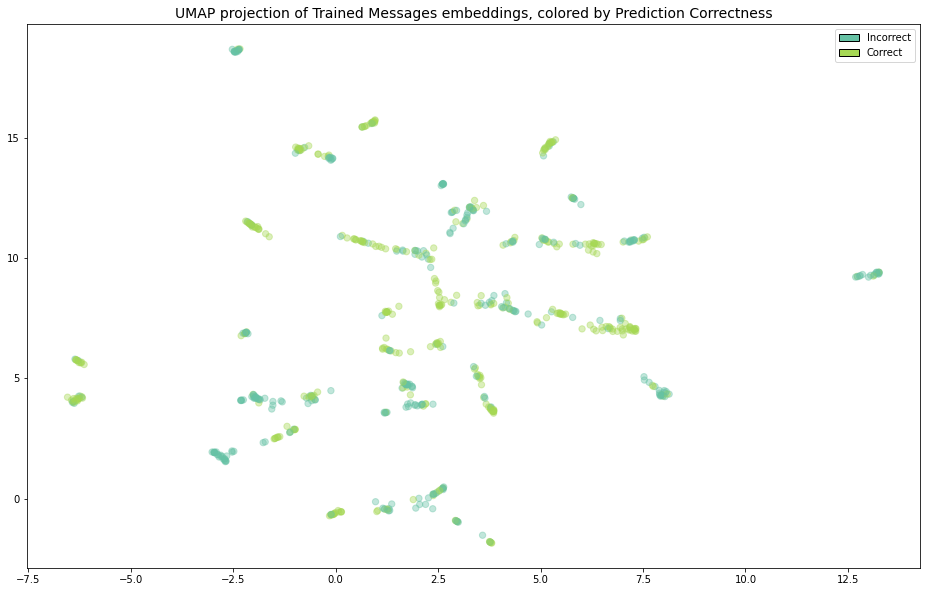

In [ ]:
# correct or incorrect only two labels
labels = ["Incorrect", "Correct"]
n_labels=2
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=cmap(results_df['right_wrong_pred_polarity']/n_labels), s=40, alpha=.4)
plt.title('UMAP projection of Trained Messages embeddings, colored by Prediction Correctness', fontsize=14)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_labels) for x in [i for i in range(n_labels)]]
]

plt.legend(handles, labels)
plt.show()

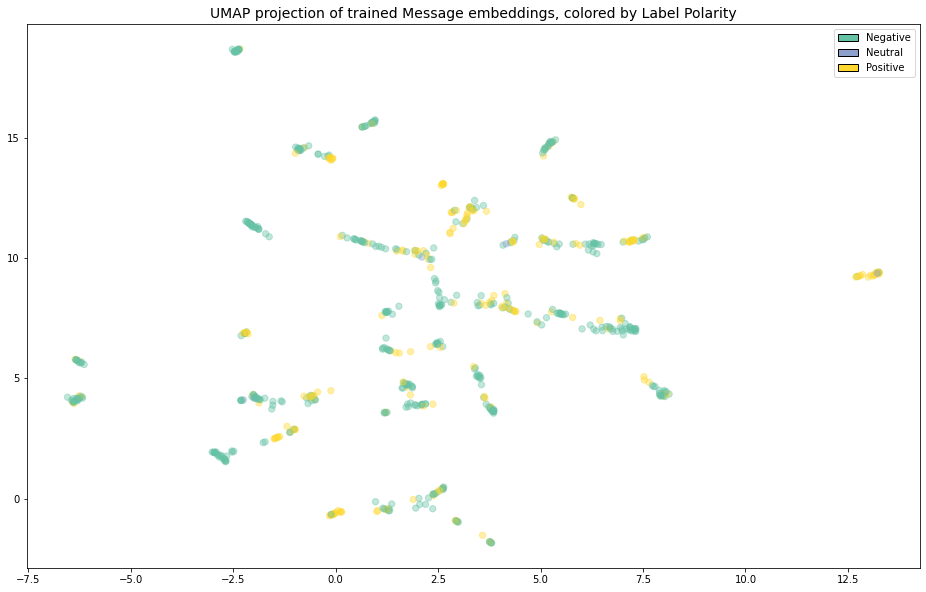

In [ ]:
# negative, neutral, positive labels
labels = ["Negative", "Neutral", "Positive"]
n_labels=3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=cmap(results_df['pos_neu_neg']/n_labels), s=40, alpha=.4)
plt.title('UMAP projection of trained Message embeddings, colored by Label Polarity', fontsize=14)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_labels) for x in [i for i in range(n_labels)]]
]

plt.legend(handles, labels)
plt.show()

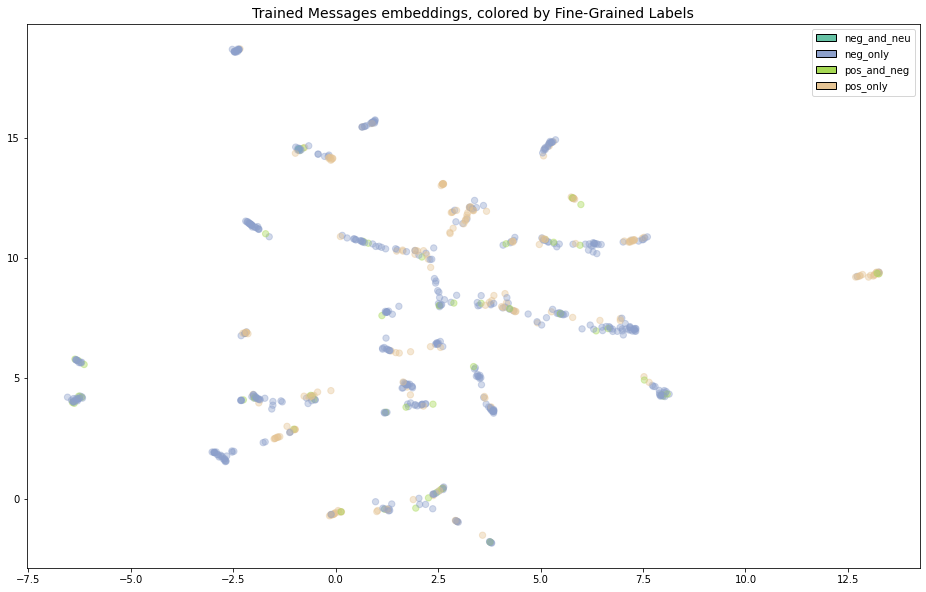

In [ ]:
# Choose number of clusters and colormap
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(results_df['poss_labels'])

n_clusters=len(set(results_df["poss_labels"]))
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=cmap(encoded_labels/n_clusters), s=40, alpha=.4)
plt.title('Trained Messages embeddings, colored by Fine-Grained Labels', fontsize=14)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in [cmap(x/n_clusters) for x in [i for i in range(n_clusters)]]
]

labels = le.classes_
plt.legend(handles, labels)
plt.show()

# Conclusions

Upon analyzing the residuals, it is clear that many of the incorrect predictions are in clusters. This suggests that further training alone may solve this problem (this model was not trained long enough to ever see validation loss go down). And, as always, a bigger model will perform better, assuming inference time is acceptable in production.

# Next Steps

- Larger models like GPT-2
- Concat features like message length, the presence of negation, any important  phrases to the pretrained vectors and tune
- Data augmentation for class balances (translate message to another language and translate back)
- Handle when no label is predicted
- Ensemble the models
- Package the polarity model with the empathy predictor 
